In [1]:
import numpy as np
import numba
from numba import cuda
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
#%matplotlib widget*
figsize=(8,4)

import rumdpy as rumd
import rumdpy as rp

In [2]:
print(numba.__version__)

0.55.1


In [3]:

def benchmark(nx, ny, nz, pb, tp, skin, 
              gridsync=True, UtilizeNIII=True, PairForceMethod='NsqNbList', steps=1000, cut=2.5, 
             integrator='NVE'):

    # Generate numpy arrays for particle positions and simbox of a FCC lattice with a given density 
    positions, simbox_data = rp.generate_fcc_positions(nx=nx, ny=ny, nz=nz, rho=0.8442)
    N, D = positions.shape
    assert N==nx*ny*nz*4, f'Wrong number particles (FCC), {N} <> {nx*ny*nz*4}'
    assert D==3, f'Wrong dimension (FCC), {D} <> {3}'

    ### Make configuration. Could be read from file or generated from single convenience function, but this shows flexibility
    c1 = rp.Configuration(N, D, simbox_data)
    c1['r'] = positions
    c1['v'] = rp.generate_random_velocities(N, D, T=1.44)
    c1['m'] =  np.ones(N, dtype=np.float32)     # Set masses
    c1.ptype = np.zeros(N, dtype=np.int32)      # Set types
   
    # Make the pair potential. NOTE: params is a 2 dimensional numpy array of tuples
    params = np.zeros((1,1), dtype="f,f,f")
    params[0][0] = (4., -4., 2.5)
    print('Pairpotential paramaters:\n', params)
    LJ = rp.PairPotential(c1, rp.apply_shifted_force_cutoff(rp.LJ_12_6), UtilizeNIII=UtilizeNIII, params=params, max_num_nbs=1000)
    num_cscalars = 3
 
    
    # NOTE: following three objects are specific to system size and other parameters for technical reasons

    interactions = rp.make_interactions(c1, pb=pb, tp=tp, pair_potential = LJ, num_cscalars=num_cscalars, 
                                        verbose=True, gridsync=gridsync, UtilizeNIII=False,)

    step_nve = rumd.make_step_nve(c1, pb=pb, tp=tp, verbose=True, gridsync=gridsync)
    step_nvt = rumd.make_step_nvt(c1, pb=pb, tp=tp, verbose=True, gridsync=gridsync)
    
    integrate_nve = rumd.make_integrator(c1, step_nve, interactions, pb=pb, tp=tp,
                                        verbose=True, gridsync=gridsync ) 
    integrate_nvt = rumd.make_integrator(c1, step_nvt, interactions, pb=pb, tp=tp,
                                        verbose=True, gridsync=gridsync )
   
    dt = np.float32(0.005)
    skin = np.float32(0.5)
    md_time_unit = 2.e-12
    print(f'dt = {dt} = {dt*md_time_unit*1e15} fs')

    c1.copy_to_device()           
    LJ.copy_to_device()
 
    interaction_params = (LJ.d_params, skin, LJ.nblist.d_nblist,  LJ.nblist.d_nbflag)
    integrator_params = (dt, )

    start = cuda.event()
    end = cuda.event()

 
    MATS = 50
    TPS = MATS*1.e6/N
       
    inner_steps = 1000
    test_steps = int(TPS*1)
    print('test_steps : ', test_steps)
    
    
    tps_max = 0.0
    skins = np.linspace(0.1, 1.4, 14)
    timings = np.zeros_like(skins)
    nblist_updates = np.zeros_like(skins)
    
    T = np.float32(0.7)
    tau=0.2
    omega2 = np.float32(4.0*np.pi*np.pi/tau/tau)
    degrees = N*D - D
    
    for i in range(len(skins)):
        c1.copy_to_device()
        LJ.copy_to_device()

        thermostat_state = np.zeros(2, dtype=np.float32)
        d_thermostat_state = cuda.to_device(thermostat_state)
        
        interaction_params = (LJ.d_params, np.float32(skins[i]), LJ.nblist.d_nblist, LJ.nblist.d_nbflag)
        nve_params = (dt, )
        nvt_params = (dt, T, omega2, degrees,  d_thermostat_state)
        start.record()
        if integrator=='NVE':
            integrate_nve(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data, interaction_params,
                        nve_params, test_steps)
        if integrator=='NVT':         
            integrate_nvt(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data, interaction_params,
                        nvt_params, test_steps)
        nbflag = LJ.nblist.d_nbflag.copy_to_host()
        end.record()
        end.synchronize()
        
        timings[i] = cuda.event_elapsed_time(start, end)
        tps = test_steps/timings[i]*1000    

        print(f'{i}, {skins[i]:.3f}, {tps:.3f}, nbflag:{nbflag}')
        if tps>tps_max:
            tps_max = tps
            skin = skins[i]
        nblist_updates[i] = nbflag[2]
        
    print('optimal skin:', skin)
    
    c1.copy_to_device()                
    LJ.copy_to_device()
    
    interaction_params = (LJ.d_params, np.float32(skins[i]), LJ.nblist.d_nblist, LJ.nblist.d_nbflag)

    start.record()
  
    scalars_t = []
    tt = []
    for i in range(steps):
        if integrator=='NVE':
            integrate_nve(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data, interaction_params,
                        nve_params, inner_steps)
        if integrator=='NVT':         
            integrate_nvt(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data, interaction_params,
                        nvt_params, inner_steps)
        scalars_t.append(np.sum(c1.d_scalars.copy_to_host(), axis=0))
        tt.append(i*inner_steps*dt)
            
    end.record()
    end.synchronize()
    timing_numba = cuda.event_elapsed_time(start, end)
    nbflag = LJ.nblist.d_nbflag.copy_to_host()    
    tps = steps*inner_steps/timing_numba*1000
    ns_per_step = dt*md_time_unit*1e9

    print('\tsteps :', steps*inner_steps)
    print('\tnbflag : ', nbflag)
    print('\ttime :', timing_numba/1000, 's')
    print('\ttime/steps :', timing_numba/(steps*inner_steps)*1000, 'us')
    print('\tTPS : ', tps )
    print('\tMATS : ', steps*inner_steps*N/timing_numba*1000/1e6)
    print('\tns/day : ', tps*ns_per_step*3600*24 )
    print('\tms/year : ', tps*ns_per_step*3600*24*1e-6*365)
    print()
   
    df = pd.DataFrame(np.array(scalars_t), columns=c1.sid.keys())
    if UtilizeNIII:
        df['u'] *= 2
        df['w'] *= 2
        df['lap'] *= 2
    df['w'] *= 1/D/2
    df['t'] = np.array(tt)  
    
    rumd.plot_scalars(df, N, D, figsize=(15,4))
    
    return  skins, timings, nblist_updates

# N=256

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVE integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVT integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  195312


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (32) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 62603.410, nbflag:[    0     0 52761]
1, 0.200, 105470.499, nbflag:[    0     0 28341]
2, 0.300, 110663.791, nbflag:[    0     0 19111]
3, 0.400, 103551.610, nbflag:[    0     0 14216]
4, 0.500, 99894.561, nbflag:[    0     0 11142]
5, 0.600, 101721.643, nbflag:[   0    0 9071]
6, 0.700, 95724.159, nbflag:[   0    0 7524]
7, 0.800, 99435.615, nbflag:[   0    0 6350]
8, 0.900, 91029.959, nbflag:[   0    0 5409]
9, 1.000, 96970.612, nbflag:[   0    0 4623]
10, 1.100, 93482.386, nbflag:[   0    0 3976]
11, 1.200, 92928.900, nbflag:[   0    0 3420]
12, 1.300, 83947.502, nbflag:[   0    0 2962]
13, 1.400, 81644.208, nbflag:[   0    0 2590]
optimal skin: 0.3
	steps : 1000000
	nbflag :  [    0     0 13258]
	time : 13.1390654296875 s
	time/steps : 13.139065429687498 us
	TPS :  76108.91393694689
	MATS :  19.483881967858405
	ns/day :  65758.100171714
	ms/year :  24.00170656267561



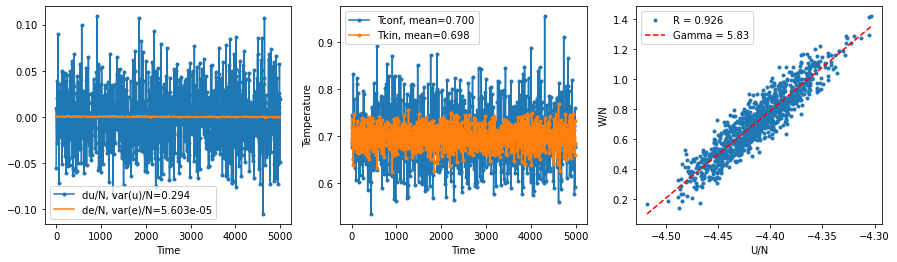

In [4]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=4, pb=8, tp=32, skin=0.4, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVE integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
Generating NVT integrator for 256 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:32
	Number (virtual) particles: 256
	Number of threads 8192
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  195312


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (32) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 58120.767, nbflag:[    0     0 52621]
1, 0.200, 96140.023, nbflag:[    0     0 28369]
2, 0.300, 98788.163, nbflag:[    0     0 19106]
3, 0.400, 91291.432, nbflag:[    0     0 14204]
4, 0.500, 93523.783, nbflag:[    0     0 11159]
5, 0.600, 93716.202, nbflag:[   0    0 9095]
6, 0.700, 91667.007, nbflag:[   0    0 7535]
7, 0.800, 87032.197, nbflag:[   0    0 6340]
8, 0.900, 89138.050, nbflag:[   0    0 5414]
9, 1.000, 84099.096, nbflag:[   0    0 4611]
10, 1.100, 78995.767, nbflag:[   0    0 3977]
11, 1.200, 84330.877, nbflag:[   0    0 3416]
12, 1.300, 81714.200, nbflag:[   0    0 2963]
13, 1.400, 72667.077, nbflag:[   0    0 2577]
optimal skin: 0.3
	steps : 1000000
	nbflag :  [    0     0 13245]
	time : 14.482740234375 s
	time/steps : 14.482740234375 us
	TPS :  69047.70670584045
	MATS :  17.676212916695157
	ns/day :  59657.217260403406
	ms/year :  21.774884300047244



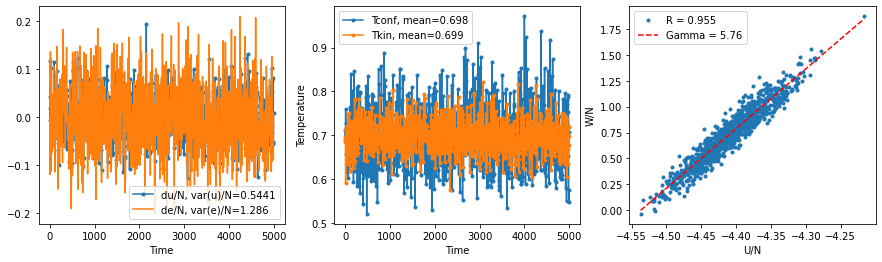

In [5]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=4, pb=8, tp=32, skin=0.4, UtilizeNIII=False, integrator='NVT')

# N=512

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 512 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 16384
Generating NVE integrator for 512 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 16384
Generating NVT integrator for 512 particles in 3 dimensions:
	pb: 8, tp:32, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  97656


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 40135.656, nbflag:[    0     0 27845]
1, 0.200, 77391.223, nbflag:[    0     0 14852]
2, 0.300, 77539.160, nbflag:[    0     0 10067]
3, 0.400, 80602.216, nbflag:[   0    0 7506]
4, 0.500, 78708.945, nbflag:[   0    0 5907]
5, 0.600, 76420.941, nbflag:[   0    0 4826]
6, 0.700, 77464.326, nbflag:[   0    0 4008]
7, 0.800, 74441.176, nbflag:[   0    0 3402]
8, 0.900, 73231.525, nbflag:[   0    0 2913]
9, 1.000, 71328.147, nbflag:[   0    0 2519]
10, 1.100, 68905.808, nbflag:[   0    0 2189]
11, 1.200, 69655.288, nbflag:[   0    0 1900]
12, 1.300, 64813.038, nbflag:[   0    0 1665]
13, 1.400, 64592.595, nbflag:[   0    0 1464]
optimal skin: 0.4
	steps : 1000000
	nbflag :  [    0     0 14967]
	time : 15.5820048828125 s
	time/steps : 15.5820048828125 us
	TPS :  64176.59393131338
	MATS :  32.85841609283245
	ns/day :  55448.57591728248
	ms/year :  20.238730209808104



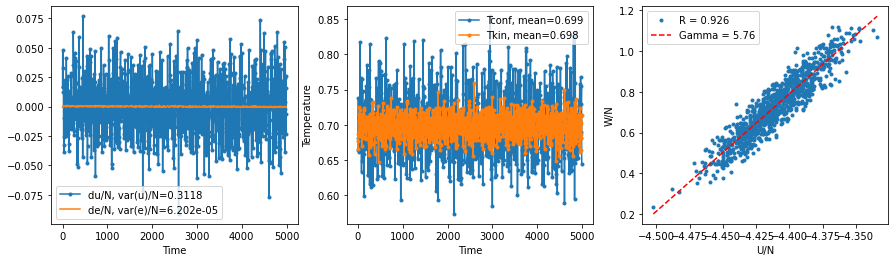

In [6]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=8, pb=8, tp=32, skin=0.4, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 512 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 8192
Generating NVE integrator for 512 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 8192
Generating NVT integrator for 512 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:64
	Number (virtual) particles: 512
	Number of threads 8192
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  97656


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 31282.265, nbflag:[    0     0 30239]
1, 0.200, 50750.024, nbflag:[    0     0 15671]
2, 0.300, 52473.220, nbflag:[    0     0 10592]
3, 0.400, 51859.690, nbflag:[   0    0 7905]
4, 0.500, 52318.863, nbflag:[   0    0 6192]
5, 0.600, 53174.351, nbflag:[   0    0 5019]
6, 0.700, 49175.403, nbflag:[   0    0 4135]
7, 0.800, 48002.837, nbflag:[   0    0 3435]
8, 0.900, 47604.661, nbflag:[   0    0 2828]
9, 1.000, 48121.431, nbflag:[   0    0 2250]
10, 1.100, 47452.706, nbflag:[   0    0 1576]
11, 1.200, 48831.344, nbflag:[  0   0 679]
12, 1.300, 46731.478, nbflag:[  0   0 239]
13, 1.400, 49386.705, nbflag:[ 0  0 16]
optimal skin: 0.6
	steps : 1000000
	nbflag :  [  0   0 632]
	time : 21.50302734375 s
	time/steps : 21.503027343750002 us
	TPS :  46505.079680822564
	MATS :  23.810600796581152
	ns/day :  40180.38794612902
	ms/year :  14.665841600337092



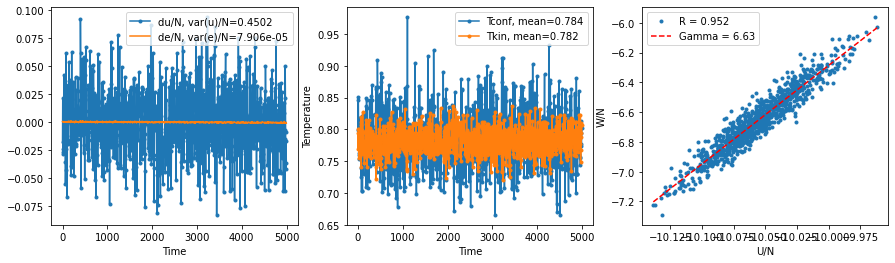

In [7]:
skins, timings, nblist_updates = benchmark(nx=4, ny=4, nz=8, pb=8, tp=16, skin=0.4)

# N=1024

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
Generating NVE integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
Generating NVT integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  48828
0, 0.100, 24235.782, nbflag:[    0     0 14934]
1, 0.200, 53695.808, nbflag:[   0    0 7780]
2, 0.300, 56702.131, nbflag:[   0    0 5269]
3, 0.400, 58154.681, nbflag:[   0    0 3939]
4, 0.500, 56723.194, nbflag:[   0    0 3109]
5, 0.600, 56124.855, nbflag:[   0    0 2544]
6, 0.700, 54997.173, nbflag:[   0    0 2130]
7, 0.800, 53288.179, nbflag:[   0    0 1808]
8, 0.900, 51346.290, nbflag:[   0    0 1555]
9, 1.000, 51366.969, nbfla

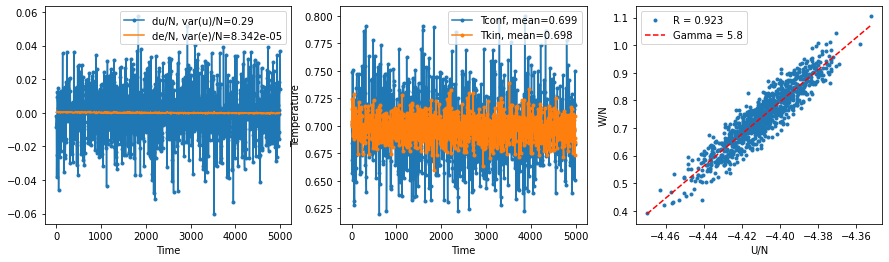

In [8]:
skins, timings, nblist_updates = benchmark(nx=4, ny=8, nz=8, pb=8, tp=16, skin=0.5, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
Generating NVE integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
Generating NVT integrator for 1024 particles in 3 dimensions:
	pb: 8, tp:16, num_blocks:128
	Number (virtual) particles: 1024
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  48828
0, 0.100, 19486.691, nbflag:[    0     0 15967]
1, 0.200, 37509.067, nbflag:[   0    0 8201]
2, 0.300, 38415.810, nbflag:[   0    0 5536]
3, 0.400, 36644.309, nbflag:[   0    0 4145]
4, 0.500, 34293.947, nbflag:[   0    0 3268]
5, 0.600, 39875.100, nbflag:[   0    0 2654]
6, 0.700, 38847.332, nbflag:[   0    0 2191]
7, 0.800, 38160.122, nbflag:[   0    0 1842]
8, 0.900, 39228.104, nbflag:[   0    0 1536]
9, 1.000, 37912.471, nbfla

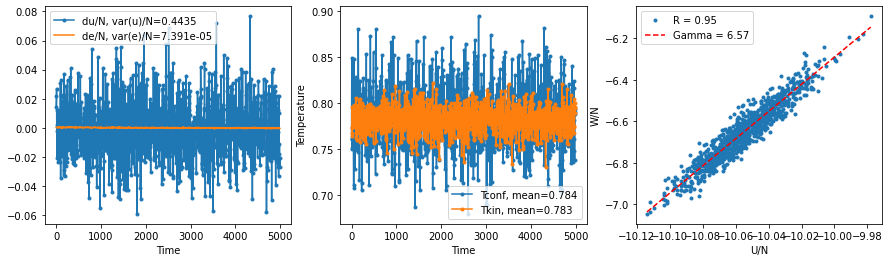

In [9]:
skins, timings, nblist_updates = benchmark(nx=4, ny=8, nz=8, pb=8, tp=16, skin=0.5)

# N=2048

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 2048 particles in 3 dimensions:
	pb: 16, tp:8, num_blocks:128
	Number (virtual) particles: 2048
	Number of threads 16384
Generating NVE integrator for 2048 particles in 3 dimensions:
	pb: 16, tp:8, num_blocks:128
	Number (virtual) particles: 2048
	Number of threads 16384
Generating NVT integrator for 2048 particles in 3 dimensions:
	pb: 16, tp:8, num_blocks:128
	Number (virtual) particles: 2048
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  24414
0, 0.100, 9158.864, nbflag:[   0    0 8130]
1, 0.200, 21516.170, nbflag:[   0    0 4233]
2, 0.300, 23344.423, nbflag:[   0    0 2878]
3, 0.400, 24541.909, nbflag:[   0    0 2161]
4, 0.500, 26120.668, nbflag:[   0    0 1708]
5, 0.600, 27232.962, nbflag:[   0    0 1393]
6, 0.700, 26775.444, nbflag:[   0    0 1155]
7, 0.800, 26657.856, nbflag:[  0   0 978]
8, 0.900, 25378.805, nbflag:[  0   0 828]
9, 1.000, 26149.280, nbflag:[  0   0

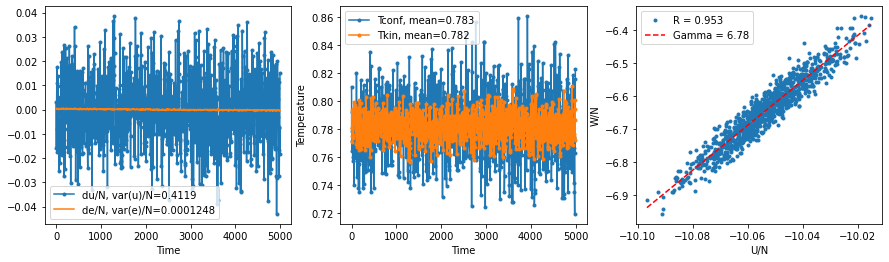

In [10]:
skins, timings, nblist_updates = benchmark(nx=8, ny=8, nz=8, pb=16, tp=8, skin=0.5)

# N=4096

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVE integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVT integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  12207
0, 0.100, 4147.289, nbflag:[   0    0 4078]
1, 0.200, 9138.717, nbflag:[   0    0 2180]
2, 0.300, 10700.446, nbflag:[   0    0 1497]
3, 0.400, 12159.907, nbflag:[   0    0 1125]
4, 0.500, 13132.182, nbflag:[  0   0 891]
5, 0.600, 13305.799, nbflag:[  0   0 726]
6, 0.700, 13285.601, nbflag:[  0   0 607]
7, 0.800, 13257.205, nbflag:[  0   0 513]
8, 0.900, 13337.870, nbflag:[  0   0 435]
9, 1.000, 13119.462, nbflag:[  0   0 371]
10, 

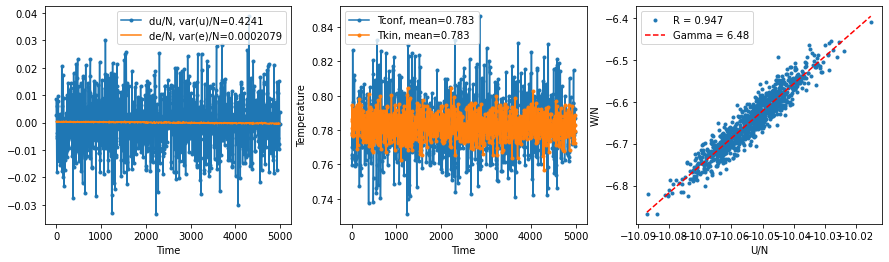

In [11]:
skins, timings, nblist_updates = benchmark(nx=8, ny=8, nz=16, pb=16, tp=4, skin=0.6)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVE integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
Generating NVT integrator for 4096 particles in 3 dimensions:
	pb: 16, tp:4, num_blocks:256
	Number (virtual) particles: 4096
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  12207
0, 0.100, 3595.979, nbflag:[   0    0 4063]
1, 0.200, 8670.795, nbflag:[   0    0 2083]
2, 0.300, 10514.529, nbflag:[   0    0 1424]
3, 0.400, 11700.762, nbflag:[   0    0 1062]
4, 0.500, 12173.942, nbflag:[  0   0 839]
5, 0.600, 12374.214, nbflag:[  0   0 686]
6, 0.700, 12744.123, nbflag:[  0   0 568]
7, 0.800, 12553.283, nbflag:[  0   0 481]
8, 0.900, 12634.327, nbflag:[  0   0 408]
9, 1.000, 12333.366, nbflag:[  0   0 343]
10, 

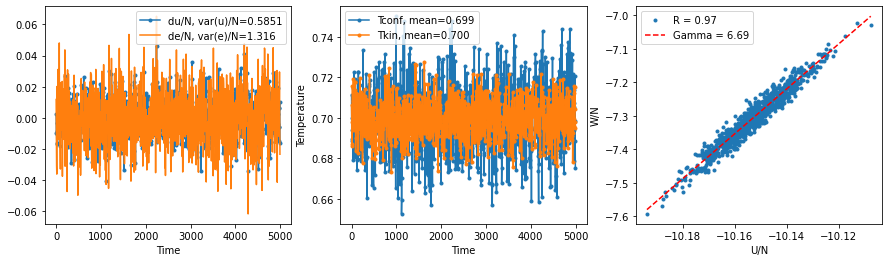

In [12]:
skins, timings, nblist_updates = benchmark(nx=8, ny=8, nz=16, pb=16, tp=4, skin=0.6, integrator='NVT')

# N=8192

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVE integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVT integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  6103
0, 0.100, 1412.933, nbflag:[   0    0 2038]
1, 0.200, 2815.225, nbflag:[   0    0 1138]
2, 0.300, 3625.044, nbflag:[  0   0 777]
3, 0.400, 4280.209, nbflag:[  0   0 583]
4, 0.500, 4759.132, nbflag:[  0   0 460]
5, 0.600, 5047.103, nbflag:[  0   0 378]
6, 0.700, 5187.175, nbflag:[  0   0 316]
7, 0.800, 5350.733, nbflag:[  0   0 270]
8, 0.900, 5505.922, nbflag:[  0   0 229]
9, 1.000, 5541.793, nbflag:[  0   0 197]
10, 1.100, 5486.740

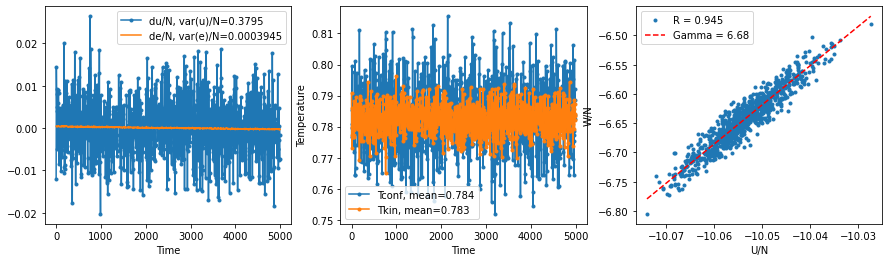

In [13]:
skins, timings, nblist_updates = benchmark(nx=8, ny=16, nz=16, pb=32, tp=2, skin=0.9)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVE integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVT integrator for 8192 particles in 3 dimensions:
	pb: 32, tp:2, num_blocks:256
	Number (virtual) particles: 8192
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  6103
0, 0.100, 1291.490, nbflag:[   0    0 2037]
1, 0.200, 2999.405, nbflag:[   0    0 1077]
2, 0.300, 3924.119, nbflag:[  0   0 740]
3, 0.400, 4637.036, nbflag:[  0   0 557]
4, 0.500, 5092.533, nbflag:[  0   0 443]
5, 0.600, 5429.546, nbflag:[  0   0 363]
6, 0.700, 5586.851, nbflag:[  0   0 308]
7, 0.800, 5736.126, nbflag:[  0   0 263]
8, 0.900, 5735.926, nbflag:[  0   0 229]
9, 1.000, 5739.458, nbflag:[  0   0 199]
10, 1.100, 5615.807

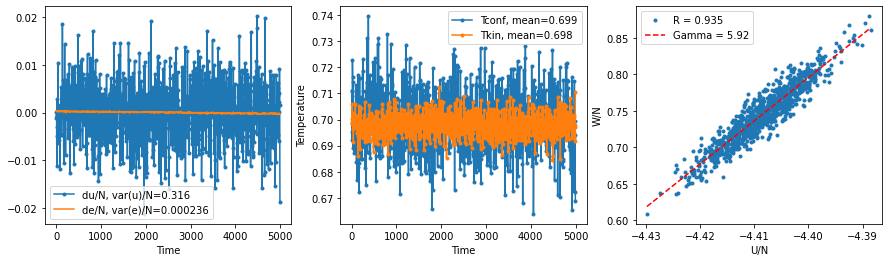

In [14]:
skins, timings, nblist_updates = benchmark(nx=8, ny=16, nz=16, pb=32, tp=2, skin=0.9, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 8192 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:128
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVE integrator for 8192 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:128
	Number (virtual) particles: 8192
	Number of threads 16384
Generating NVT integrator for 8192 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:128
	Number (virtual) particles: 8192
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  6103
0, 0.100, 1388.569, nbflag:[   0    0 2039]
1, 0.200, 2713.818, nbflag:[   0    0 1140]
2, 0.300, 3561.658, nbflag:[  0   0 776]
3, 0.400, 4238.359, nbflag:[  0   0 580]
4, 0.500, 4701.685, nbflag:[  0   0 464]
5, 0.600, 5009.971, nbflag:[  0   0 380]
6, 0.700, 5168.747, nbflag:[  0   0 318]
7, 0.800, 5346.100, nbflag:[  0   0 268]
8, 0.900, 5455.815, nbflag:[  0   0 231]
9, 1.000, 5513.538, nbflag:[  0   0 200]
10, 1.100, 5476.313

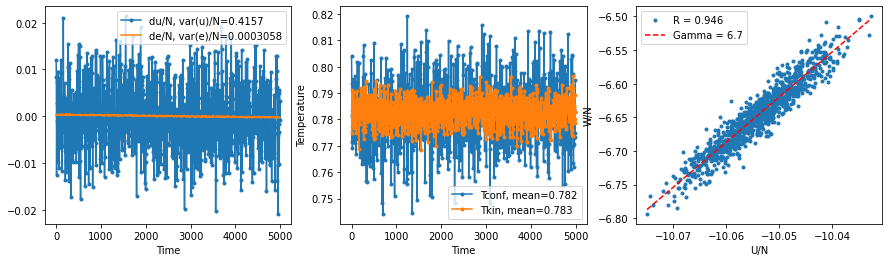

In [15]:
skins, timings, nblist_updates = benchmark(nx=8, ny=16, nz=16, pb=64, tp=2, skin=0.9)

# N=16384

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 406.284, nbflag:[   0    0 1023]
1, 0.200, 741.394, nbflag:[  0   0 596]
2, 0.300, 1032.640, nbflag:[  0   0 398]
3, 0.400, 1272.044, nbflag:[  0   0 301]
4, 0.500, 1483.991, nbflag:[  0   0 239]
5, 0.600, 1644.347, nbflag:[  0   0 197]
6, 0.700, 1774.803, nbflag:[  0   0 166]
7, 0.800, 1915.618, nbflag:[  0   0 140]
8, 0.900, 2032.184, nbflag:[  0   0 121]
9, 1.000, 2114.603, nbflag:[  0   0 104]
10, 1.100, 2166.75

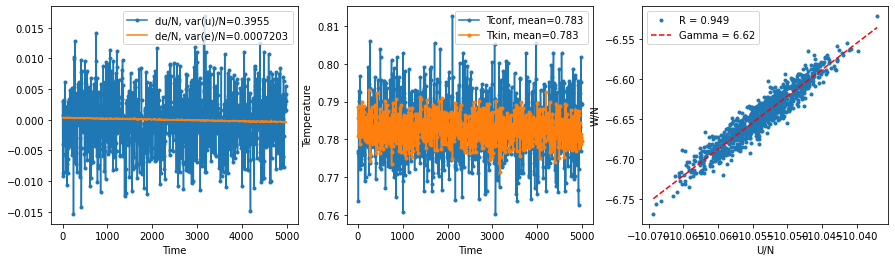

In [16]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=1, skin=1.0, gridsync=True, UtilizeNIII=True)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 382.142, nbflag:[   0    0 1021]
1, 0.200, 778.336, nbflag:[  0   0 554]
2, 0.300, 1046.216, nbflag:[  0   0 381]
3, 0.400, 1281.267, nbflag:[  0   0 287]
4, 0.500, 1491.239, nbflag:[  0   0 227]
5, 0.600, 1648.170, nbflag:[  0   0 185]
6, 0.700, 1759.682, nbflag:[  0   0 156]
7, 0.800, 1894.351, nbflag:[  0   0 131]
8, 0.900, 2006.138, nbflag:[  0   0 112]
9, 1.000, 2085.611, nbflag:[ 0  0 96]
10, 1.100, 2119.646, 

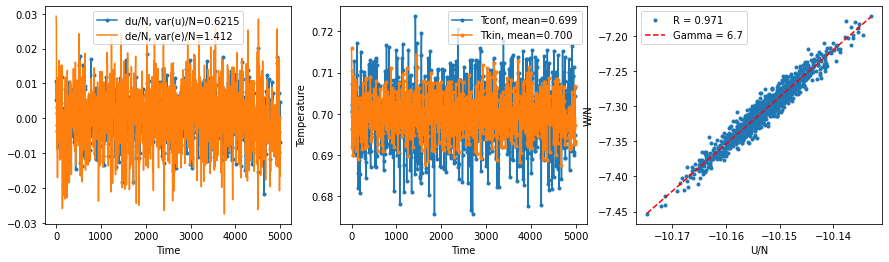

In [17]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=1, skin=1.0, gridsync=True, UtilizeNIII=True, integrator='NVT')

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:1, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 16384
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 408.908, nbflag:[   0    0 1019]
1, 0.200, 807.759, nbflag:[  0   0 552]
2, 0.300, 1110.728, nbflag:[  0   0 379]
3, 0.400, 1377.291, nbflag:[  0   0 286]
4, 0.500, 1608.920, nbflag:[  0   0 228]
5, 0.600, 1790.453, nbflag:[  0   0 188]
6, 0.700, 1937.593, nbflag:[  0   0 159]
7, 0.800, 2051.797, nbflag:[  0   0 137]
8, 0.900, 2135.724, nbflag:[  0   0 120]
9, 1.000, 2204.402, nbflag:[  0   0 105]
10, 1.100, 2222.91

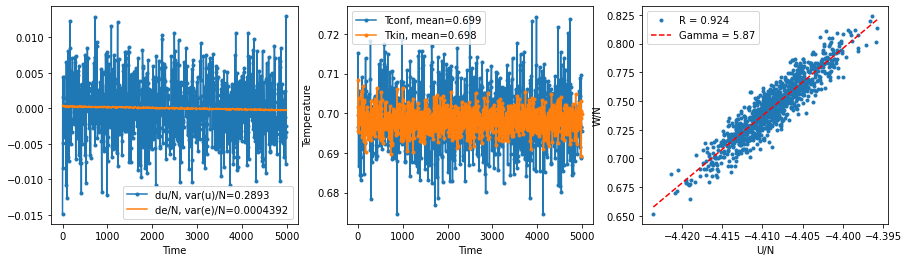

In [18]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=1, skin=1.0, gridsync=True, UtilizeNIII=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 522.686, nbflag:[   0    0 1022]
1, 0.200, 969.080, nbflag:[  0   0 595]
2, 0.300, 1336.105, nbflag:[  0   0 397]
3, 0.400, 1627.641, nbflag:[  0   0 301]
4, 0.500, 1872.565, nbflag:[  0   0 240]
5, 0.600, 2075.331, nbflag:[  0   0 196]
6, 0.700, 2230.646, nbflag:[  0   0 165]
7, 0.800, 2381.331, nbflag:[  0   0 143]
8, 0.900, 2545.055, nbflag:[  0   0 121]
9, 1.000, 2660.879, nbflag:[  0   0 103]
10, 1.100, 2720.59

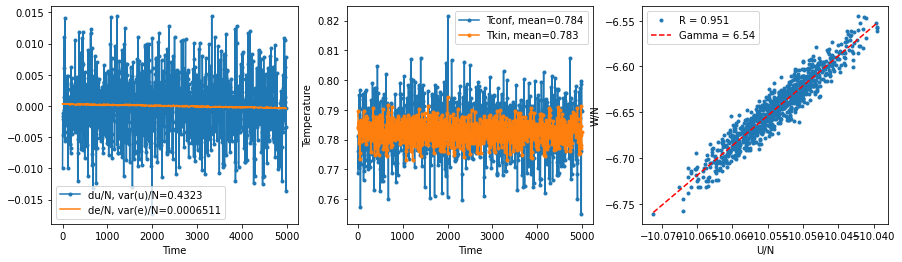

In [19]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=2, skin=1.0, gridsync=False, UtilizeNIII=True)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 475.240, nbflag:[   0    0 1020]
1, 0.200, 1034.776, nbflag:[  0   0 553]
2, 0.300, 1368.989, nbflag:[  0   0 381]
3, 0.400, 1645.343, nbflag:[  0   0 284]
4, 0.500, 1799.624, nbflag:[  0   0 226]
5, 0.600, 1785.134, nbflag:[  0   0 185]
6, 0.700, 1783.530, nbflag:[  0   0 155]
7, 0.800, 1784.641, nbflag:[  0   0 131]
8, 0.900, 1795.957, nbflag:[  0   0 112]
9, 1.000, 1796.161, nbflag:[ 0  0 97]
10, 1.100, 1791.167, nbflag:[ 0  0 84]
11, 1.200, 1784.865, nbflag:[ 0  0 69]
12, 1.300, 1771.977, nbflag:[ 0  0 50]
13, 1.400, 1792.175, nbflag:[ 0  0 15]
optimal skin: 0.5
	steps : 1000000
	nbflag :  [    0     0 10856]
	time : 559.543875 s
	time/steps : 559.5438750000001 us
	TPS :  1787.169951596736
	MATS :  29.280992486960923
	ns/day :  1544.1148036659238
	ms/year :  0.5636019033380621



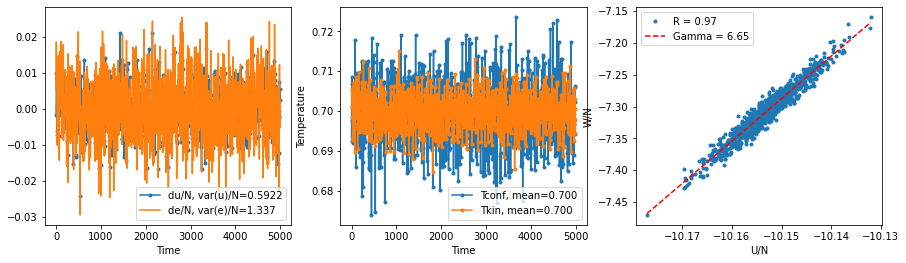

In [20]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=2, skin=1.0, gridsync=False, UtilizeNIII=True, integrator='NVT')

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVE integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
Generating NVT integrator for 16384 particles in 3 dimensions:
	pb: 64, tp:2, num_blocks:256
	Number (virtual) particles: 16384
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  3051
0, 0.100, 540.459, nbflag:[   0    0 1021]
1, 0.200, 1111.247, nbflag:[  0   0 561]
2, 0.300, 1518.887, nbflag:[  0   0 384]
3, 0.400, 1882.421, nbflag:[  0   0 288]
4, 0.500, 2194.622, nbflag:[  0   0 230]
5, 0.600, 2453.748, nbflag:[  0   0 190]
6, 0.700, 2690.622, nbflag:[  0   0 159]
7, 0.800, 2848.354, nbflag:[  0   0 139]
8, 0.900, 2965.341, nbflag:[  0   0 120]
9, 1.000, 2967.293, nbflag:[  0   0 106]
10, 1.100, 2971.6

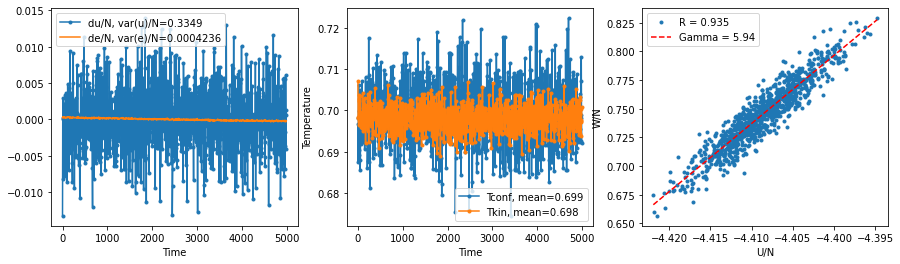

In [21]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=16, pb=64, tp=2, skin=1.0, gridsync=False, UtilizeNIII=False)

# N=32768

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVE integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVT integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  1525
0, 0.100, 139.156, nbflag:[  0   0 513]
1, 0.200, 251.642, nbflag:[  0   0 306]
2, 0.300, 361.953, nbflag:[  0   0 205]
3, 0.400, 457.763, nbflag:[  0   0 154]
4, 0.500, 535.805, nbflag:[  0   0 124]
5, 0.600, 616.003, nbflag:[  0   0 102]
6, 0.700, 662.863, nbflag:[ 0  0 87]
7, 0.800, 716.878, nbflag:[ 0  0 73]
8, 0.900, 732.664, nbflag:[ 0  0 63]
9, 1.000, 780.158, nbflag:[ 0  0 54]
10, 1.100, 789.887, nbflag:[ 0  0 47]


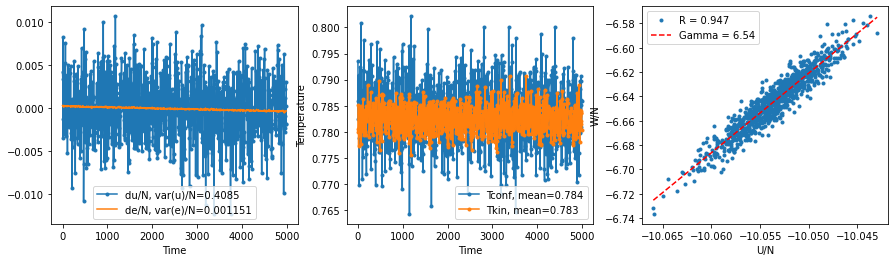

In [22]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=32, pb=128, tp=1, skin=1.0, gridsync=False)

Pairpotential paramaters:
 [[(4., -4., 2.5)]]
Generating interactions for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVE integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
Generating NVT integrator for 32768 particles in 3 dimensions:
	pb: 128, tp:1, num_blocks:256
	Number (virtual) particles: 32768
	Number of threads 32768
dt = 0.004999999888241291 = 9.999999776482582 fs
test_steps :  1525


/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/tbs/anaconda3/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0, 0.100, 148.212, nbflag:[  0   0 512]
1, 0.200, 274.618, nbflag:[  0   0 290]
2, 0.300, 379.518, nbflag:[  0   0 198]
3, 0.400, 478.269, nbflag:[  0   0 148]
4, 0.500, 560.778, nbflag:[  0   0 118]
5, 0.600, 624.324, nbflag:[ 0  0 97]
6, 0.700, 678.608, nbflag:[ 0  0 81]
7, 0.800, 716.875, nbflag:[ 0  0 69]
8, 0.900, 787.579, nbflag:[ 0  0 58]
9, 1.000, 783.362, nbflag:[ 0  0 51]
10, 1.100, 807.586, nbflag:[ 0  0 44]
11, 1.200, 800.067, nbflag:[ 0  0 39]
12, 1.300, 840.445, nbflag:[ 0  0 31]
13, 1.400, 841.396, nbflag:[ 0  0 24]
optimal skin: 1.4
	steps : 1000000
	nbflag :  [    0     0 14697]
	time : 1195.8805 s
	time/steps : 1195.8805 us
	TPS :  836.2039518162559
	MATS :  27.400731093115073
	ns/day :  722.4801982205539
	ms/year :  0.2637052723505022



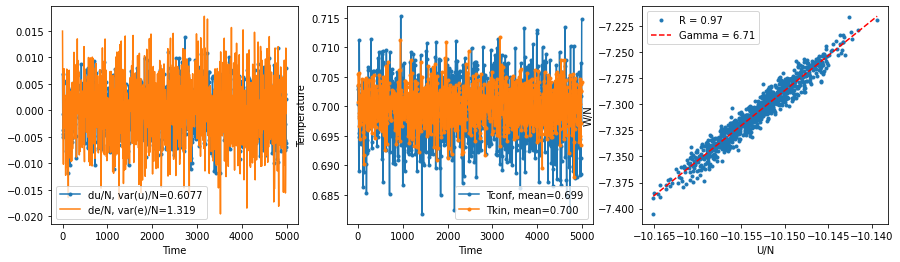

In [23]:
skins, timings, nblist_updates = benchmark(nx=16, ny=16, nz=32, pb=128, tp=1, skin=1.0, gridsync=False, UtilizeNIII=True, integrator='NVT')

# Benchmarks

In [24]:

Ns = np.array([512, 1024, 2048, 4096, 8192, 16384, 32768])
TPS_rumd_1080 = np.array([35354, 34226, 31454, 17508, 8824, 6617, 3075])
TPS_rumdpy_3070lap_11 = np.array([80549, 63196, 37959, 17010, 6495, 3441, 872])
TPS_rumdpy_3070lap_12 = np.array([72585, 57683, 37063, 20163, 9180, 3341, 1174])
TPS_rumdpy_3070lap_15 = np.array([80607, 63118, 36931, 20413, 9365, 3365, 1179])
TPS_rumdpy_3070lap_19 = np.array([80789, 63171, 37593, 21635, 9431, 3241, 1165])
TPS_rumdpy_3070lap_25 = np.array([82198, 58611, 34459, 19226, 8300, 3387, 1086])
TPS_rumdpy_3070lap_27 = np.array([81754, 58291, 34427, 18839, 8208, 3462, 1103])
TPS_rumdpy_3070lap_28 = np.array([82215, 60171, 35793, 18839, 8208, 3462, 1103])


print(f'Speed-up: {(TPS_rumdpy_3070lap_27/TPS_rumdpy_3070lap_11)}')

Speed-up: [1.01495984 0.92238433 0.90695224 1.10752499 1.26374134 1.00610288
 1.26490826]


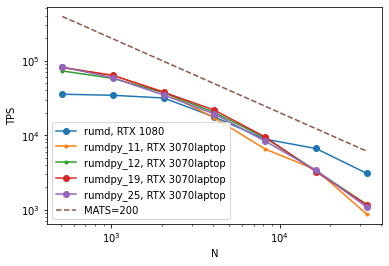

In [25]:
### plt.figure(figsize=(12,8))
plt.loglog(Ns, TPS_rumd_1080, 'o-', label='rumd, RTX 1080')
plt.loglog(Ns, TPS_rumdpy_3070lap_11, '.-', label='rumdpy_11, RTX 3070laptop')
plt.loglog(Ns, TPS_rumdpy_3070lap_12, '.-', label='rumdpy_12, RTX 3070laptop')
plt.loglog(Ns, TPS_rumdpy_3070lap_19, 'o-', label='rumdpy_19, RTX 3070laptop')
plt.loglog(Ns, TPS_rumdpy_3070lap_25, 'o-', label='rumdpy_25, RTX 3070laptop')
plt.loglog(Ns, 200*1e6/Ns, '--', label='MATS=200')
plt.legend()
plt.xlabel('N')
plt.ylabel('TPS')
plt.show()